# **Movie recommender system using KNN**











Connecting the google colab with google drive to store and use the movielens 1m dataset

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Loading the movie ratings dataset 

In [4]:
movie_ratings = pd.read_csv("/content/drive/MyDrive/Movie recommendation system/ml-1m/ratings.dat",sep='::',names=['userId','movieId','rating','timestamp'])
movie_ratings

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


Counting the total number of rows in the movie ratings dataset

In [5]:
movie_ratings.count()

userId       1000209
movieId      1000209
rating       1000209
timestamp    1000209
dtype: int64

Checking for the presence of null values

In [6]:
movie_ratings.isnull().values.any()

False

Check for the presence of duplicates values

In [7]:
movie_ratings.duplicated().values.any()

False

Loading the movie title dataset

In [8]:
movie_title = pd.read_csv("/content/drive/MyDrive/Movie recommendation system/ml-1m/movies.dat",sep='::',names=['movieId','title','genres'])
movie_title.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Counting the total number of rows in the movie title genres dataset

In [9]:
movie_title.count()

movieId    3883
title      3883
genres     3883
dtype: int64

Checking for the presence of null values

In [10]:
movie_title.isnull().values.any()


False

Check for the presence of duplicates values

In [11]:
movie_title.duplicated().values.any()

False

In [12]:
movie_title.describe()

,movieId
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


## EDA and data pre-processing

In [13]:
movie_title['year']=movie_title.title.str.extract('(\(\d\d\d\d\))', expand=False)
movie_title['year']

0       (1995)
1       (1995)
2       (1995)
3       (1995)
4       (1995)
         ...  
3878    (2000)
3879    (2000)
3880    (2000)
3881    (2000)
3882    (2000)
Name: year, Length: 3883, dtype: object

In [14]:
movie_title['year']=movie_title.year.str.extract('(\d\d\d\d)')
movie_title['year']

0       1995
1       1995
2       1995
3       1995
4       1995
        ... 
3878    2000
3879    2000
3880    2000
3881    2000
3882    2000
Name: year, Length: 3883, dtype: object

In [15]:
movie_title['title']=movie_title.title.str.replace('(\(\d\d\d\d\))','')
movie_title['title']

0                         Toy Story 
1                           Jumanji 
2                  Grumpier Old Men 
3                 Waiting to Exhale 
4       Father of the Bride Part II 
                    ...             
3878               Meet the Parents 
3879            Requiem for a Dream 
3880                      Tigerland 
3881               Two Family House 
3882                 Contender, The 
Name: title, Length: 3883, dtype: object

In [16]:
movie_title['title']=movie_title.title.apply(lambda x:x.strip())
movie_title['title']

0                         Toy Story
1                           Jumanji
2                  Grumpier Old Men
3                 Waiting to Exhale
4       Father of the Bride Part II
                   ...             
3878               Meet the Parents
3879            Requiem for a Dream
3880                      Tigerland
3881               Two Family House
3882                 Contender, The
Name: title, Length: 3883, dtype: object

In [17]:
movie_title['genres']=movie_title.genres.str.split('|')
movie_title.head(10)

,movieId,title,genres,year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995
5,6,Heat,"[Action, Crime, Thriller]",1995
6,7,Sabrina,"[Comedy, Romance]",1995
7,8,Tom and Huck,"[Adventure, Children's]",1995
8,9,Sudden Death,[Action],1995
9,10,GoldenEye,"[Action, Adventure, Thriller]",1995


#We will be recommending movies to users based on two methods:

###Method 1.   Recommendation using user ratings (Using KNN).
###Method 2.   Recommendation using the popular Genres (Using KNN).


##Method 1:

Joining the 'Movie ratings' and 'Movie title' dataset based on movieID column

In [18]:
merged_data = movie_ratings.merge(movie_title,on='movieId')
merged_data.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,[Drama],1975
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest,[Drama],1975
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest,[Drama],1975
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest,[Drama],1975
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest,[Drama],1975


Counting the total number of rows in the merged dataset

In [19]:
merged_data.count()

userId       1000209
movieId      1000209
rating       1000209
timestamp    1000209
title        1000209
genres       1000209
year         1000209
dtype: int64

Check the presence of null values

In [20]:
merged_data.isnull().values.any()

False

Lets look at the mean of all user ratings related to individual title.

In [21]:
merged_data.groupby(by='title')['rating'].mean()

title
$1,000,000 Duck                        3.027027
'Night Mother                          3.371429
'Til There Was You                     2.692308
'burbs, The                            2.910891
...And Justice for All                 3.713568
                                         ...   
Zed & Two Noughts, A                   3.413793
Zero Effect                            3.750831
Zero Kelvin (Kj�rlighetens kj�tere)    3.500000
Zeus and Roxanne                       2.521739
eXistenZ                               3.256098
Name: rating, Length: 3664, dtype: float64

Sorting the above obtained mean values in descending order to view the highest rated movies by the users.

In [22]:
merged_data.groupby(by='title')['rating'].mean().sort_values(ascending=False)

title
Ulysses (Ulisse)                              5.0
Schlafes Bruder (Brother of Sleep)            5.0
Smashing Time                                 5.0
Song of Freedom                               5.0
Gate of Heavenly Peace, The                   5.0
                                             ... 
Mutters Courage                               1.0
Loves of Carmen, The                          1.0
Fantastic Night, The (La Nuit Fantastique)    1.0
Elstree Calling                               1.0
Cheetah                                       1.0
Name: rating, Length: 3664, dtype: float64

We can clearly see that movies such as 'The Gate of Heavenly Peace', 'Lured', Ulysses and many more are the highest rated movies by the users. Further, movies such as 'Kestrel's Eye', 'Windows' etc are the lease rated movies.

Lets see how many number of people who have rated these movies.

In [23]:
merged_data.groupby(by='title')['rating'].count().sort_values(ascending=False)

title
American Beauty                                   3428
Star Wars: Episode IV - A New Hope                2991
Star Wars: Episode V - The Empire Strikes Back    2990
Star Wars: Episode VI - Return of the Jedi        2883
Jurassic Park                                     2672
                                                  ... 
Running Free                                         1
Daens                                                1
Hippie Revolution, The                               1
Hillbillys in a Haunted House                        1
Legal Deceit                                         1
Name: rating, Length: 3664, dtype: int64

As per the query results, movie by name 'American Beauty' is rated by highest no of people. However, on the other hand, for instance, movie by name 'Night Tide' is the rated just one person. It barely has even 5 people's rating.

Creating a new dataframe to only store the columns movie title and its corresponding average ratings by by the users

In [24]:
EDA_df=pd.DataFrame(merged_data.groupby(by='title')['rating'].mean())

In [25]:
EDA_df.head(10)

,rating
title,
"$1,000,000 Duck",3.027027
'Night Mother,3.371429
'Til There Was You,2.692308
"'burbs, The",2.910891
...And Justice for All,3.713568
1-900,2.500000
10 Things I Hate About You,3.422857
101 Dalmatians,3.381055
12 Angry Men,4.295455


Grouping the ratings based on each movie titles to come up with total number of ratings

In [26]:
EDA_df['total_rating_count']=merged_data.groupby(by='title')['rating'].count()
EDA_df.head(10)

,rating,total_rating_count
title,,
"$1,000,000 Duck",3.027027,37
'Night Mother,3.371429,70
'Til There Was You,2.692308,52
"'burbs, The",2.910891,303
...And Justice for All,3.713568,199
1-900,2.500000,2
10 Things I Hate About You,3.422857,700
101 Dalmatians,3.381055,929
12 Angry Men,4.295455,616


.

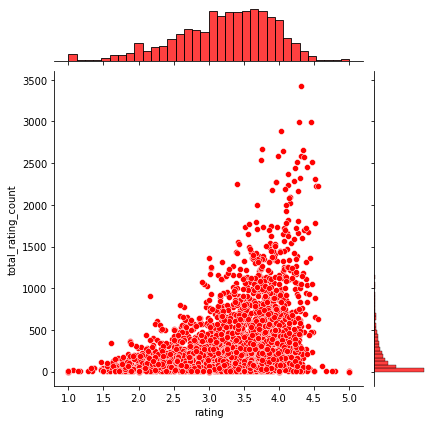

In [27]:
sns.jointplot(x=EDA_df['rating'],y=EDA_df['total_rating_count'], color="r")

Another way using a feature 'hex' to better visualize the total rating count falling between the range 1 to 5 via joint plot. 

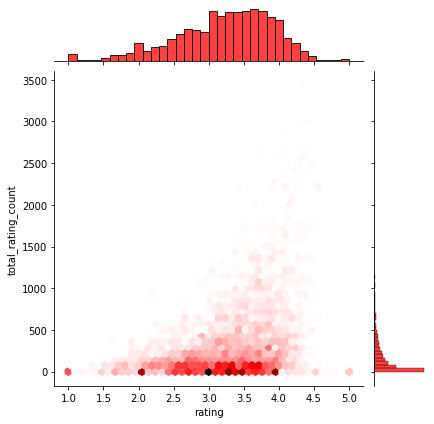

In [28]:
sns.jointplot(x=EDA_df['rating'],y=EDA_df['total_rating_count'],kind='hex',color="r");

Plotting the histogram to see the distribution

Text(0.5, 1.0, 'Movie ratings')

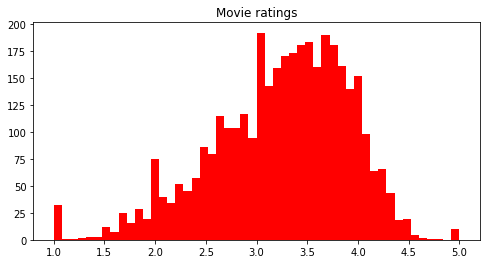

In [29]:
plt.figure(figsize=(8,4))
plt.hist(EDA_df['rating'], bins=50,color='r',) 
plt.title('Movie ratings')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


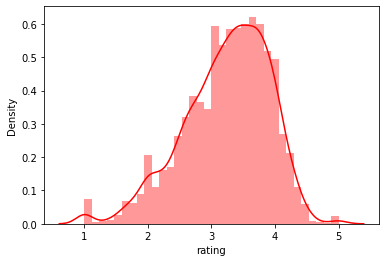

In [30]:
sns.distplot(EDA_df['rating'], color='r');

Dropping the column such as 'rating' from the dataframe since we already have the total count of ratings.

In [31]:
movie_rating_count =EDA_df.drop(columns=['rating'])
movie_rating_count

,total_rating_count
title,
"$1,000,000 Duck",37
'Night Mother,70
'Til There Was You,52
"'burbs, The",303
...And Justice for All,199
...,...
"Zed & Two Noughts, A",29
Zero Effect,301
Zero Kelvin (Kj�rlighetens kj�tere),2


Merging the above dataframe with the merged data dataframe

In [32]:
merged_rating_count_data = merged_data.merge(movie_rating_count, left_on = 'title', right_on = 'title')
merged_rating_count_data.head()

,userId,movieId,rating,timestamp,title,genres,year,total_rating_count
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,[Drama],1975,1725
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest,[Drama],1975,1725
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest,[Drama],1975,1725
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest,[Drama],1975,1725
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest,[Drama],1975,1725


In [33]:
df=movie_title.drop(columns=['genres','year'])
df.head()

,movieId,title
0,1,Toy Story
1,2,Jumanji
2,3,Grumpier Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


Removing unnecessary columns

In [34]:
merged_rating_count_data=merged_rating_count_data.drop(['title','timestamp','genres','total_rating_count','year',],axis=1)
merged_rating_count_data.head()

,userId,movieId,rating
0,1,1193,5
1,2,1193,5
2,12,1193,4
3,15,1193,4
4,17,1193,5


Creating pivot table to come up with a matrix

In [35]:
matrix=merged_rating_count_data.pivot_table(index='movieId',columns='userId',values='rating')
matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,3.0,NaN,4.0,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,5.0,5.0,NaN,5.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN,3.0,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,3.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


Changing the Nan value to 0 

In [36]:
movie_matrix=matrix.fillna(0)
movie_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,3.0,0.0,4.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [37]:
!pip install fuzzywuzzy

Use scipy library to import a function called 'csr_matrix' to convert a dense matrix to a sparse matrix.

In [38]:
from scipy.sparse import csr_matrix

movie_matrix_array = csr_matrix(movie_matrix.values)


## Model building for method 1

We use Knearest neighbours model to train the model and cosine similarity as metric, where the nearest neighbors value is considered as 25.

In [39]:
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
from numpy import nan
KNN_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors=25)

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Create a function to intake the movie name, data, KNN model and the number of recommendataions, to out the similar recommendations.

In [40]:
def recommendation(movie_name,dataset ,mymodel, num_of_recommendations):
    mymodel.fit(dataset)
    index=process.extractOne(movie_name, df['title'])[2]
    print('Movie Selected is : ',df['title'][index])
    movie = df[df['title'].str.contains(movie_name)]
    print('Possible matches: ',movie.title.values)
    print("The recommendations are : ")
    distances,indices=mymodel.kneighbors(dataset[index], n_neighbors=num_of_recommendations+1)
    for i in indices:
       print(df['title'][i].where(i!=index)[1:])

### Results

Recommending the similar movies to the user based on the user rating

In [41]:
recommendation('Nadine',movie_matrix_array,KNN_model,10)

Movie Selected is :  Nadine
Possible matches:  ['Nadine']
The recommendations are : 
1612                                Life Less Ordinary, A
2903                         Red Sorghum (Hong Gao Liang)
2015                                              Newsies
2029                                       Son of Flubber
3083                               Last Picture Show, The
1522                                       Batman & Robin
3611    Decline of Western Civilization Part II: The M...
2842                         Grandfather, The (El Abuelo)
2561                                Besieged (L' Assedio)
2753                                         Medicine Man
Name: title, dtype: object


# Method 2 :

## EDA and data pre-processing

In [42]:
genres = {}

def ExtractGenres(x):
    for g in x:
        if g not in genres.keys():
            genres[g] = 1
        else:
            genres[g] = genres[g] + 1

merged_data["genres"].apply(ExtractGenres)

0          None
1          None
2          None
3          None
4          None
           ... 
1000204    None
1000205    None
1000206    None
1000207    None
1000208    None
Name: genres, Length: 1000209, dtype: object

Visualizing top 10 Genres

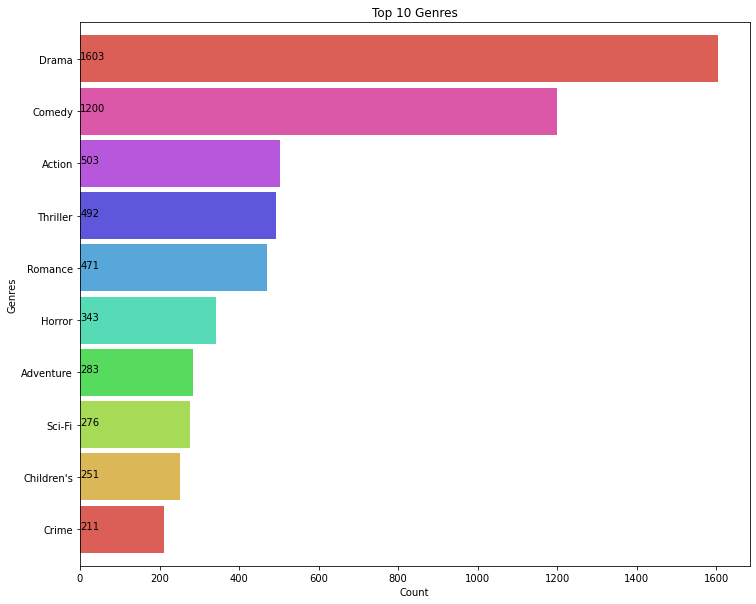

In [43]:
plt.subplots(figsize=(12,10))
genre_list= []
for i in movie_title['genres']:
    genre_list.extend(i)
ax = pd.Series(genre_list).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',9))
for i, v in enumerate(pd.Series(genre_list).value_counts()[:10].sort_values(ascending=True).values): 
  ax.text(.9, i, v,fontsize=10,color='black')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.title('Top 10 Genres')
plt.show()

Visulizing the Genre distribution

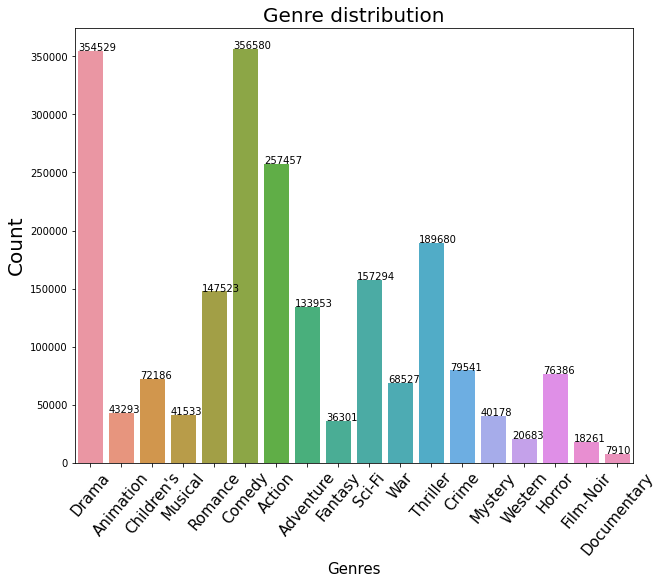

In [44]:
df = pd.DataFrame(list(genres.items()))
df.columns = ["Genre", "Count"] 
fig, axes = plt.subplots(1, 1, figsize=(10, 8), sharey=True)
sns.barplot(y="Count", x="Genre", data=df, ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))
plt.tick_params(labelsize = 20)
plt.title("Genre distribution", fontsize = 20)
plt.xlabel("Genres", fontsize = 15)
plt.xticks(rotation=50, fontsize=15)
plt.yticks(fontsize=10)
plt.ylabel("Count", fontsize = 20)
plt.show()

Visualizing the count of each ratings


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


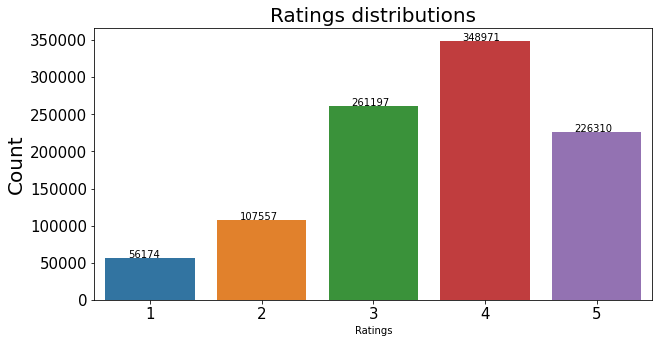

In [45]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
sns.countplot("rating", data=merged_data, ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))
plt.tick_params(labelsize = 15)
plt.title("Ratings distributions", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Count", fontsize = 20)
plt.show()

Calculating the number of ratings given by individual users based on their userID.  

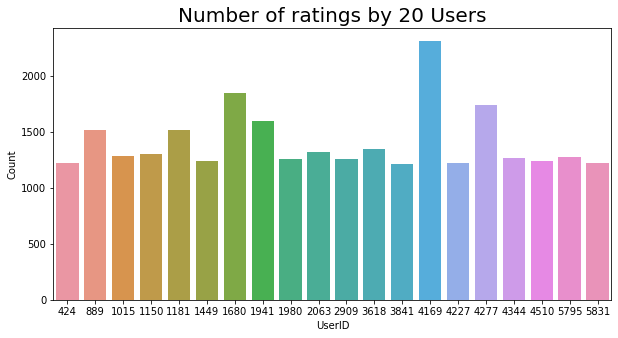

In [46]:
count_of_userMovieRating= movie_ratings.groupby(by=["userId"], as_index=False)["rating"].count().sort_values(by="rating", ascending=False)
count_of_userMovieRating.reset_index(drop=True, inplace=True)

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))
sns.barplot(x="userId", y="rating" , data=count_of_userMovieRating[:20], ax=axes)
plt.tick_params(labelsize = 10)
plt.title("Number of ratings by 20 Users", fontsize = 20)
plt.xlabel("UserID", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Count", fontsize = 10)
plt.show()


Visualizing the count of ratings by 20 individual users

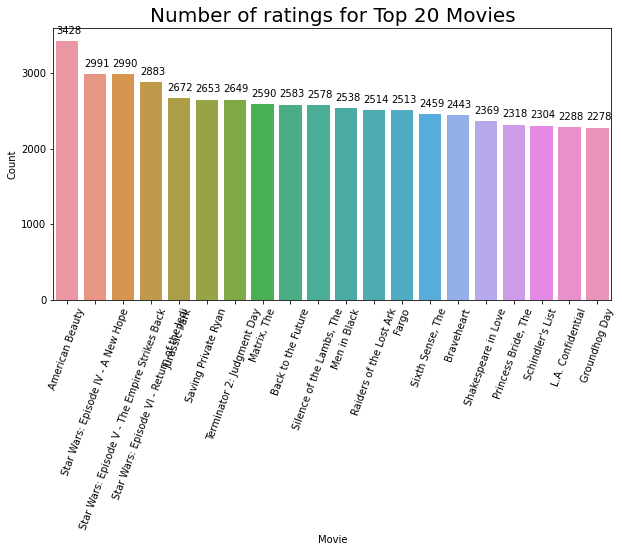

In [47]:
count_of_ratings_for_movies= merged_data.groupby(by=["title"], as_index=False)["rating"].count().sort_values(by="rating", ascending=False)
count_of_ratings_for_movies.reset_index(drop=True, inplace=True)

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
sns.barplot(x="title", y="rating", data=count_of_ratings_for_movies[:20], ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))
plt.tick_params(labelsize = 20)
plt.title("Number of ratings for Top 20 Movies", fontsize = 20)
plt.xlabel("Movie", fontsize = 10)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Count", fontsize = 10)
plt.yticks(fontsize=10)
plt.show()

Reading the movie file again to preserve the year

Split the content of the genre based by replacing pipe with comma.

In [48]:
movie_title = pd.read_csv("/content/drive/MyDrive/Movie recommendation system/ml-1m/movies.dat",sep='::',names=['movieId','title','genres'])
movie_title.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [49]:
movie_title['genres']=movie_title.genres.str.split('|')
movie_title.head(10)

,movieId,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]
5,6,Heat (1995),"[Action, Crime, Thriller]"
6,7,Sabrina (1995),"[Comedy, Romance]"
7,8,Tom and Huck (1995),"[Adventure, Children's]"
8,9,Sudden Death (1995),[Action]
9,10,GoldenEye (1995),"[Action, Adventure, Thriller]"


Grouping the user rating based on MovieID to calculate the average rating for each movie with the corresponding number of ratings

In [50]:
rating_average=movie_ratings.groupby('movieId').agg({'rating': [np.size,np.mean]})
rating_average.head()

rating          
          size      mean
movieId                 
1         2077  4.146846
2          701  3.201141
3          478  3.016736
4          170  2.729412
5          296  3.006757

In [51]:
rating_average.columns = rating_average.columns.droplevel(0)
print(rating_average.head())

         size      mean
movieId                
1        2077  4.146846
2         701  3.201141
3         478  3.016736
4         170  2.729412
5         296  3.006757


Normalizing the rating size values between 0 and 1 for better analysis.

In [52]:
Total_ratings=pd.DataFrame(rating_average['size'])
ratings_normalized=Total_ratings.apply(lambda x: (x-np.min(x))/(np.max(x) - np.min(x)))
ratings_normalized

,size
movieId,
1,0.605778
2,0.204260
3,0.139189
4,0.049314
5,0.086081
...,...
3948,0.251240
3949,0.088416
3950,0.015465


Checking the unique Genres

In [53]:
genre_list = []
for index, row in movie_title.iterrows():
    genres = row["genres"]
    for genre in genres:
        if genre not in genre_list:
            genre_list.append(genre)
print('The list of Genres are:', genre_list)

The list of Genres are: ['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir', 'Western']


Assigning value 1 if a genre is present, else 0

In [54]:
def encoding(genre_list1):
    binary_list = []
    
    for genre in genre_list:
        if genre in genre_list1:
            binary_list.append(1)
        else:
            binary_list.append(0)
    
    return binary_list

In [55]:
movie_title['genres_encoded'] = movie_title['genres'].apply(lambda x: encoding(x))
movie_title['genres_encoded']

0       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
3878    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3879    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
3880    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
3881    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
3882    [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...
Name: genres_encoded, Length: 3883, dtype: object

Dropping of the unnecessary columns

In [56]:
reduced_movie_title=movie_title.drop(columns=['genres'])
reduced_movie_title.shape

(3883, 3)

Merging the columns with average rating and normalized rating with the 'reduced_movie_title' dataframe.

In [57]:
merged_rating_with_movie_genre=reduced_movie_title.merge(ratings_normalized,left_index=True, right_index=True)
merged_rating_with_movie_genre=merged_rating_with_movie_genre.merge(rating_average,left_index=True, right_index=True)
merged_rating_with_movie_genre=merged_rating_with_movie_genre.rename(columns={'size_x':'normalized_rating','mean': 'average_rating'})
merged_rating_with_movie_genre.head(10)

,movieId,title,genres_encoded,normalized_rating,size_y,average_rating
1,2,Jumanji (1995),"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.605778,2077,4.146846
2,3,Grumpier Old Men (1995),"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.204260,701,3.201141
3,4,Waiting to Exhale (1995),"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.139189,478,3.016736
4,5,Father of the Bride Part II (1995),"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.049314,170,2.729412
5,6,Heat (1995),"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...",0.086081,296,3.006757
6,7,Sabrina (1995),"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.274001,940,3.878723
7,8,Tom and Huck (1995),"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.133353,458,3.410480
8,9,Sudden Death (1995),"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.019551,68,3.014706
9,10,GoldenEye (1995),"[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",0.029472,102,2.656863
10,11,"American President, The (1995)","[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.258827,888,3.540541


Iterating through dataframes to create the corresponding dictionary with movieID as key as rest as values

In [58]:
movie_dictionary = {}
for index, row in merged_rating_with_movie_genre.iterrows():
  movie_dictionary[row['movieId']] = {
      "movieId" : row['movieId'],
      "title" : row['title'],
      "genres_encoded": row['genres_encoded'],
      "normalized_rating" : row['normalized_rating'],
      "average_rating" : row['average_rating']}

print(movie_dictionary[5])

{'movieId': 5, 'title': 'Father of the Bride Part II (1995)', 'genres_encoded': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'normalized_rating': 0.049314269039976655, 'average_rating': 2.7294117647058824}


### Model Building for method 2

Creating a user defined function that calculates the cosine similarity based on Genre and normalized rating of the movies and compute the distance.

In [59]:
from scipy import spatial

def Distance(a, b):
    genre_a=movie_dictionary[a]['genres_encoded']
    genre_b=movie_dictionary[b]['genres_encoded']
    genre_distance = spatial.distance.cosine(genre_a, genre_b)

    genre_popularity_a = movie_dictionary[a]['normalized_rating']
    genre_popularity_b = movie_dictionary[b]['normalized_rating']
    
    genre_popularity_distance=abs(genre_popularity_a-genre_popularity_b)
    return (genre_distance+genre_popularity_distance)


In [60]:
print(Distance(3,246))

1.2016340822877152


Iterating through the rows to create dictionary that takes title as key and value as the movie ID

In [61]:
movie_title_to_id = {}
for index, row in merged_rating_with_movie_genre.iterrows():
  movie_title_to_id[row['title']] = row['movieId']

In [62]:
def helper(title):
    return movie_title_to_id[title]

Considering the movie title, find the K-Nearest Neighbors by caluclating the distance based on the popular genre and normalized rating.

In [63]:
import operator
def KNN(title,num_of_neighbors):
  movieId = helper(title)
  calc_distance=[]
  print('Movie Selected is : {0} and the MovieID is {1}'.format(movie_dictionary[movieId]['title'],movie_dictionary[movieId]['movieId']))
  for movie in movie_dictionary:
      if (movie!=movieId):
        distance=Distance(movieId, movie)
        calc_distance.append((movie,distance))
  calc_distance.sort(key=operator.itemgetter(1))     
  nearest_neighbors=[]
  for i in range(num_of_neighbors):
    nearest_neighbors.append(calc_distance[i][0])
  return nearest_neighbors


### Results

We have got 10 recommendations for the movie 'GoldenEye (1995)' based on the K-Nearest Neighbors

In [64]:
average_rating=0

#Give the movie name and the number of recommendations you want

num_of_neighbors=10
neighbors=KNN('GoldenEye (1995)',num_of_neighbors)
print("The recommendations are....")

y_values=[]
for neighbor in neighbors:
  average_rating+=movie_dictionary[neighbor]['average_rating']
  y_values.append(movie_dictionary[neighbor]['average_rating'])
  print(movie_dictionary[neighbor]['title'],movie_dictionary[neighbor]['average_rating'])

average_rating/=float(num_of_neighbors)

Movie Selected is : GoldenEye (1995) and the MovieID is 10
The recommendations are....
Maximum Risk (1996) 3.94
Firestorm (1998) 3.717948717948718
Perfect Storm, The (2000) 3.2542372881355934
Rock, The (1996) 3.0865384615384617
Clear and Present Danger (1994) 3.8059701492537314
Mummy, The (1999) 2.2285714285714286
Abyss, The (1989) 4.095744680851064
Spawn (1997) 2.704225352112676
Runaway Train (1985) 3.3661971830985915
Escape from New York (1981) 3.0


In [65]:
print("The average rating of 10 nearest neighbors to movie GoldenEye is",average_rating)

The average rating of 10 nearest neighbors to movie GoldenEye is 3.3199433261510265


In [66]:
print(y_values)

[3.94, 3.717948717948718, 3.2542372881355934, 3.0865384615384617, 3.8059701492537314, 2.2285714285714286, 4.095744680851064, 2.704225352112676, 3.3661971830985915, 3.0]


## Evaluation:

Lets compare the actual rating of the movie 'Golden' eye with the obtained average rating to see the difference.

In [67]:
print('The actual rating of the movie {0} is  {1} and the average rating is {2}'.format(movie_dictionary[10]['title'],movie_dictionary[10]['average_rating'],average_rating))

The actual rating of the movie GoldenEye (1995) is  2.656862745098039 and the average rating is 3.3199433261510265


In [68]:
print('The values of actual values of 10 neighbor movies:',(y_values))

The values of actual values of 10 neighbor movies: [3.94, 3.717948717948718, 3.2542372881355934, 3.0865384615384617, 3.8059701492537314, 2.2285714285714286, 4.095744680851064, 2.704225352112676, 3.3661971830985915, 3.0]


In [69]:
rounded_y=[]
for i in y_values:
  rounded_y.append(round(i,2))
print(rounded_y)

[3.94, 3.72, 3.25, 3.09, 3.81, 2.23, 4.1, 2.7, 3.37, 3.0]


In [70]:
y_pred=[]
for i in range (10):
    y_pred.append(round(average_rating,3))
print(y_pred)

[3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32]


In [71]:
import math
y_actual = rounded_y
y_pred = y_pred
 
MSE = np.square(np.subtract(y_actual,y_pred)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error of KNN is: {}".format(RMSE))

Root Mean Square Error of KNN is: 0.5592941980746805


Reference taken from:

https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea

https://www.analyticsvidhya.com/blog/2020/08/recommendation-system-k-nearest-neighbors/